In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from tllib.ranking import negative_conditional_entropy as nce
from tllib.ranking import log_expected_empirical_prediction as leep

from sklearn.metrics.pairwise import paired_cosine_distances
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.metrics.pairwise import haversine_distances
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.metrics.pairwise import paired_cosine_distances
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp
from scipy.spatial import distance
from scipy.stats import entropy
from scipy.special import kl_div
from scipy.stats import pearsonr

from sklearn.metrics import mean_absolute_percentage_error

In [4]:
from scipy.stats import entropy
from scipy.spatial.distance import jensenshannon
from scipy.special import kl_div

def compute_probs(data, n=10): 
    h, e = np.histogram(data, n)
    p = h/data.shape[0]
    return e, p

def support_intersection(p, q): 
    sup_int = (
        list(
            filter(
                lambda x: (x[0]!=0) & (x[1]!=0), zip(p, q)
            )
        )
    )
    return sup_int

def get_probs(list_of_tuples): 
    p = np.array([p[0] for p in list_of_tuples])
    q = np.array([p[1] for p in list_of_tuples])
    return p, q

def kl_divergence(p, q): 
    return np.sum(p*np.log(p/q))

def js_divergence(p, q):
    m = (1./2.)*(p + q)
    return (1./2.)*kl_divergence(p, m) + (1./2.)*kl_divergence(q, m)

def compute_kl_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the KL Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)

    list_of_tuples = support_intersection(p, q)
    p, q = get_probs(list_of_tuples)
    
    return kl_divergence(p, q)

def compute_js_divergence(train_sample, test_sample, n_bins=10): 
    """
    Computes the JS Divergence using the support 
    intersection between two different samples
    """
    e, p = compute_probs(train_sample, n=n_bins)
    _, q = compute_probs(test_sample, n=e)
    
    list_of_tuples = support_intersection(p,q)
    p, q = get_probs(list_of_tuples)
    
    return js_divergence(p, q)

In [31]:
def mmd_linear(Sx, Sy, Tx, Ty):
            XX = np.dot(Sx, Tx)
            YY = np.dot(Sy, Ty)
            XY = np.dot(Sx, Ty)
            return XX.mean() + YY.mean() - 2 * XY.mean()

In [32]:
# Compute MMD (maximum mean discrepancy) using numpy and scikit-learn.

import numpy as np
from sklearn import metrics


def mmd_linear(X, Y):
    """MMD using linear kernel (i.e., k(x,y) = <x,y>)
    Note that this is not the original linear MMD, only the reformulated and faster version.
    The original version is:
        def mmd_linear(X, Y):
            XX = np.dot(X, X.T)
            YY = np.dot(Y, Y.T)
            XY = np.dot(X, Y.T)
            return XX.mean() + YY.mean() - 2 * XY.mean()

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Returns:
        [scalar] -- [MMD value]
    """
    delta = X.mean(0) - Y.mean(0)
    return delta.dot(delta.T)


def mmd_rbf(X, Y, gamma=1.0):
    """MMD using rbf (gaussian) kernel (i.e., k(x,y) = exp(-gamma * ||x-y||^2 / 2))

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        gamma {float} -- [kernel parameter] (default: {1.0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.rbf_kernel(X, X, gamma)
    YY = metrics.pairwise.rbf_kernel(Y, Y, gamma)
    XY = metrics.pairwise.rbf_kernel(X, Y, gamma)
    return XX.mean() + YY.mean() - 2 * XY.mean()


def mmd_poly(X, Y, degree=2, gamma=1, coef0=0):
    """MMD using polynomial kernel (i.e., k(x,y) = (gamma <X, Y> + coef0)^degree)

    Arguments:
        X {[n_sample1, dim]} -- [X matrix]
        Y {[n_sample2, dim]} -- [Y matrix]

    Keyword Arguments:
        degree {int} -- [degree] (default: {2})
        gamma {int} -- [gamma] (default: {1})
        coef0 {int} -- [constant item] (default: {0})

    Returns:
        [scalar] -- [MMD value]
    """
    XX = metrics.pairwise.polynomial_kernel(X, X, degree, gamma, coef0)
    YY = metrics.pairwise.polynomial_kernel(Y, Y, degree, gamma, coef0)
    XY = metrics.pairwise.polynomial_kernel(X, Y, degree, gamma, coef0)
    return XX.mean() + YY.mean() - 2 * XY.mean()


if __name__ == '__main__':
    a = np.arange(1, 10).reshape(3, 3)
    b = [[7, 6, 5], [4, 3, 2], [1, 1, 8], [0, 2, 5]]
    b = np.array(b)
    print(a)
    print(b)
    print(mmd_linear(a, b))  # 6.0
    print(mmd_rbf(a, b))  # 0.5822
    print(mmd_poly(a, b))  # 2436.5

[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[7 6 5]
 [4 3 2]
 [1 1 8]
 [0 2 5]]
6.0
0.5822068619587334
2436.5


In [39]:
df = pd.DataFrame()

In [44]:
# kann eine Metrik verwendet werden um die Gleichheit der Regressions DF abzubinden ?
from sklearn.datasets import make_regression

# create features and targets
features, target = make_regression(n_samples=201, 
                                 n_features=100, 
                                 n_informative=10, 
                                 n_targets=1, 
                                 bias=0.0, 
                                 effective_rank=None, 
                                 tail_strength=0.2, 
                                 noise=0.0, 
                                 shuffle=True, 
                                 coef=False, 
                                 random_state=None)

df_1 = pd.DataFrame(features,target).reset_index(names="y")

# create features and targets
features, target = make_regression(n_samples=201, 
                                 n_features=100, 
                                 n_informative=10, 
                                 n_targets=1, 
                                 bias=0.0, 
                                 effective_rank=None, 
                                 tail_strength=0.2, 
                                 noise=0.0, 
                                 shuffle=True, 
                                 coef=False, 
                                 random_state=None)

df_2 = pd.DataFrame(features,target).reset_index(names="y")

list_percentage = np.arange(0, 201, 1).tolist()

list_results = []

for i in list_percentage:

    save_values = []
    save_values.append(i)

    df_combined = df_1[:201-i].append(df_2[201-i:])

    #Kullback-Leibler Divergenz
    kld = compute_kl_divergence(df_combined, df_2) # kl(df_combined, df_2).numpy()
    save_values.append(kld)
        
    #Euclidean Distance
    ed = euclidean_distances(df_combined, df_2).mean()
    save_values.append(ed)
        
    # Cosine Distances
    cd = paired_cosine_distances(df_combined,df_2).mean()
    save_values.append(cd)

    # Manhattan Distances
    md = manhattan_distances(df_combined,df_2).mean()
    save_values.append(md)

    # Wasserstein Distance
    was = wasserstein_distance(df_combined["y"],df_2["y"])
    save_values.append(was)

    # A-Distance
    x = 1#proxy_a_distance(df_1,df_2)
    save_values.append(x)

    # Ad-Distance
    ad = ks_2samp(df_combined["y"],df_2["y"])[0]
    save_values.append(ad)

    # Jensen Shannon
    js = compute_js_divergence(df_combined,df_2)
    save_values.append(js)

    # Pearson correlation coefficient
    cor = pearsonr(df_combined["y"],df_2["y"])[0]
    save_values.append(cor)

    # MMD
    mmd = mmd_linear(df_2,df_combined)
    save_values.append(mmd)


    list_results.append(save_values)

#Visualize Sub-results
#fig, ax = plt.subplots(dpi=100)
#plt.scatter(df_combined["x"],df_combined["y"])

df = df.append(pd.DataFrame(list_results, columns =['Anteil','Kld', 'Ed', 'Cd', 'Md', 'Was', 'A', 'Ad','Js','Cor','Mmd']))

In [45]:
df_grouped = df.groupby(df.index).mean()
df_grouped

,Anteil,Kld,Ed,Cd,Md,Was,A,Ad,Js,Cor,Mmd
0,0.0,0.061616,219.092406,1.005132,330.391020,31.738017,1.0,0.099502,0.010064,0.026225,591.518508
1,1.0,0.061472,218.921704,0.999354,330.221061,31.458342,1.0,0.100498,0.010037,0.027304,562.473229
2,2.0,0.060972,218.979516,0.993694,330.281853,30.703431,1.0,0.099502,0.009881,0.032512,504.755473
3,3.0,0.061081,219.576233,0.987356,330.876331,30.636169,1.0,0.098507,0.009837,0.042918,548.950808
4,4.0,0.060577,219.783043,0.983375,331.072894,30.497724,1.0,0.097512,0.009710,0.047416,544.532358
...,...,...,...,...,...,...,...,...,...,...,...
196,196.0,0.003030,223.425283,0.020893,333.871799,2.794665,1.0,0.011940,0.000261,0.974708,4.771843
197,197.0,0.002659,223.651443,0.017042,334.092156,2.602657,1.0,0.009950,0.000167,0.979173,4.229783
198,198.0,0.002476,223.532274,0.012613,333.964732,2.153142,1.0,0.006965,0.000122,0.981636,3.387253
199,199.0,0.001299,223.758993,0.006943,334.194279,1.756069,1.0,0.005970,0.000076,0.989840,2.019307


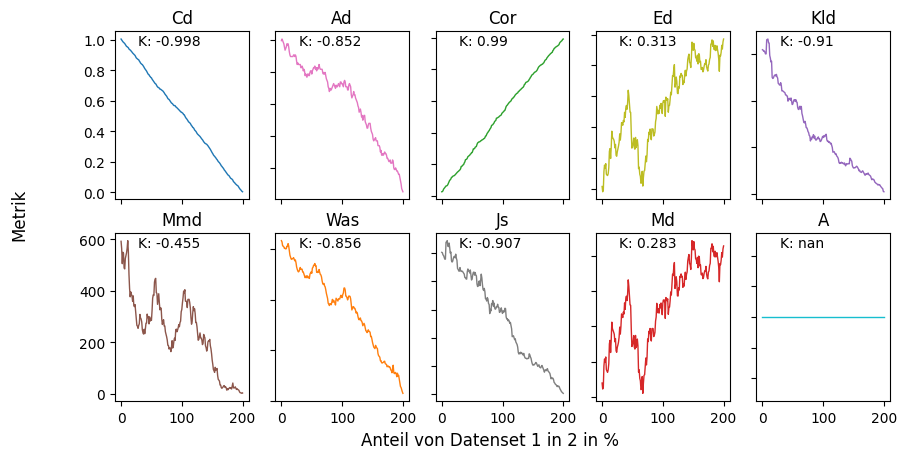

In [46]:
# Plot Metrics and d

metrics= ['Cd', 'Was', 'Cor', 'Md','Kld', 'Mmd', 'Ad', 'Js', 'Ed', 'A']
colours= ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf','#1f77b4']
hor= [0,1,2,3,4,0,1,2,3,4]
ver= [0,1,0,1,0,1,0,1,0,1]

fig, axs = plt.subplots(2, 5)

c = 0
for i in metrics:
    # Berechnung der Korrelation anhand der Schrittgröße 
    df_test = df.reset_index()
    list_range = np.arange(0, len(df), 201).tolist()
    values =[]

    for f in list_range:

        values.append(df["Anteil"][f:f+201].corr(df[i][f:f+201]))

    #print(values,sum(values)/len(values))
    #print("Mogel: ",df["Anteil"].corr(df[i]))

    axs[ver[c], hor[c]].plot(df_grouped["Anteil"], df_grouped[i], c=colours[c], label=i, linewidth=1)
    axs[ver[c], hor[c]].set_title(i)
    axs[ver[c], hor[c]].text(hor[c]*1.2-4.7, ver[c]*-1.2+2.15, 'K: '+str(round(sum(values)/len(values), 3)), transform=ax.transAxes)
    c+=1

fig.supxlabel('Anteil von Datenset 1 in 2 in %')
fig.supylabel('Metrik')
fig.set_figwidth(10) 

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()